# Chapter 31- ING Entrainment of E - Cells

### Create nodes
The ING network, E-cells, and external input nodes are defined

In [1]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 400

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Save E - Cell Nodes

In [2]:
net.build()
net.save_nodes(output_dir='network')

### Creating ING network

In [3]:
# ING network
n_ING = 100

INGnet = NetworkBuilder('INGnet')
INGnet.add_nodes(N=n_ING, pop_name='ING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules

In [4]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 0
    return 1

### Creating ING Edges

In [5]:
g_ee = 0
g_ei = 0
g_ie = 0.5
g_ii = 0.5
g_gap = 0.1

p_gap = 0.05
p_ee = 1
p_ei = 0.5
p_ie = 0.5
p_ii = 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections dont exist (g_ei = 0)

#I-I connections
INGnet.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
INGnet.add_edges(source={'pop_name':'ING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')

#gap junctions
INGnet.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'}, 
                      syn_weight=g_gap,
                      weight_function=None,
                      target_sections=['soma'],
                      model_template='Gap',
                      distance_range=[0.0, 0.1],
                      is_gap_junction=True,
                      connection_rule=syn_connector, 
                      connection_params={'p':p_gap})

In [6]:
INGnet.build()
INGnet.save_nodes(output_dir='network')
INGnet.save_edges(output_dir='network')

### Current Clamps for E-Cells and ING network

In [7]:
import h5py

current_amplitude = 0.5

i_ext=[]
for i in range(500):
    i_ext.append(current_amplitude)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=500.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 file_current_clamp={              
                      "input_type": "file_current_clamp",
                      "module": "FileIClamp",
                      "input_file":"input/amps.h5",
                      "node_set":"all"
                 },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-02-01 10:49:47,595 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-02-01 10:49:47,714 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-02-01 10:49:48,121 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-02-01 10:49:54,335 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 500.000 ms with the time step 0.100 ms


2021-02-01 10:49:54,355 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-02-01 10:49:54,385 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2021-02-01 10:50:38,096 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2021-02-01 10:50:38,180 [INFO] Simulation completed in 43.84 seconds 


INFO:NEURONIOUtils:Simulation completed in 43.84 seconds 


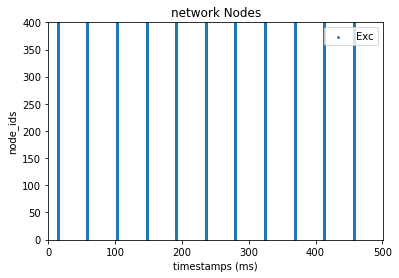

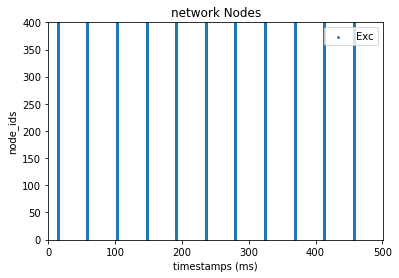

In [14]:
from bmtk.analyzer.spike_trains import plot_raster

plot_raster(config_file='simulation_config.json', with_histogram=False, population='network', group_by='pop_name')